In [2]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, LassoCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, RFE, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### 1) Simple EDA

In [3]:
train_data = pd.read_csv('./train.csv')
test_data =pd.read_csv('./test.csv')

In [4]:
train_data.shape

(199523, 41)

In [5]:
test_data.shape

(99762, 41)

In [6]:
# Concatenate Train and Test Data
X = pd.concat([train_data.iloc[:, :-1], test_data.iloc[:, :-1]])
y = train_data.iloc[:, -1]

In [7]:
# Change ' ?' to nan value
X[X == ' ?'] = np.nan

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299285 entries, 0 to 99761
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   AGE                   299285 non-null  int64 
 1   CLSWKR                299285 non-null  object
 2   DTINRC                299285 non-null  int64 
 3   DTOCRC                299285 non-null  int64 
 4   EDU                   299285 non-null  object
 5   WPH                   299285 non-null  int64 
 6   EIEDUINLW             299285 non-null  object
 7   MAST                  299285 non-null  object
 8   MAINDC                299285 non-null  object
 9   MAOCC                 299285 non-null  object
 10  RACE                  299285 non-null  object
 11  HISPOG                299285 non-null  object
 12  SEX                   299285 non-null  object
 13  MEMOFLAUNI            299285 non-null  object
 14  REAFORUNEMP           299285 non-null  object
 15  FUORPATIEMPST     

In [11]:
y.value_counts()

0    187194
1     12329
Name: INCOME, dtype: int64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='INCOME', ylabel='count'>

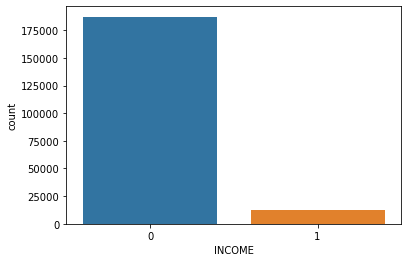

In [10]:
sns.countplot(train_data['INCOME'])

The dataset is imbalanced, so under/oversampling, threshold tuning, and other methods for handling imbalancedness could be helpful.

### 2) Missing Value

In [113]:
# Check the total number of missing values
print(f'Number of na value : {X.isna().sum().sum()}')

Number of na value : 624096


In [114]:
# I check that many missing values occurred in some columns
X.isna().sum(0).unique()

array([     0,   1038, 149642,  10142,   9191,   5157])

In [115]:
X.isna().sum(0).value_counts()

0         32
149642     4
1038       1
10142      1
9191       1
5157       1
dtype: int64

I checked which columns had missing values over 20000 and decided to delete those columns.

In [116]:
X.columns[(X.isna().sum(0) > 20000)]

Index(['MIGCCINMSA', 'MIGCCINREG', 'MIGCMWIREG', 'MIGPRERESINSUN'], dtype='object')

In [117]:
print(X.columns[(X.isna().sum(0) == 10142)][0])
print(X.columns[(X.isna().sum(0) == 9191)][0])
print(X.columns[(X.isna().sum(0) == 5157)][0])
print(X.columns[(X.isna().sum(0) == 1038)][0])

COUNOFBIRFA
COUNOFBIRMA
COUNOFBIRSE
STAOFPRERES


In [118]:
drop_column = X.columns[(X.isna().sum(0) > 20000)]
X.drop(drop_column, axis=1, inplace=True)
col = X.columns

In [119]:
print(col)

Index(['AGE', 'CLSWKR', 'DTINRC', 'DTOCRC', 'EDU', 'WPH', 'EIEDUINLW', 'MAST',
       'MAINDC', 'MAOCC', 'RACE', 'HISPOG', 'SEX', 'MEMOFLAUNI', 'REAFORUNEMP',
       'FUORPATIEMPST', 'CAPGAIN', 'CAPLOSS', 'DIVFROMSTO', 'TAXFILST',
       'REGOFPRERES', 'STAOFPRERES', 'DTHOUANDFAMST', 'DTHOUSUMINHOU',
       'LIVINTHISHO1YR', 'NUMPERWOFOREMP', 'FAMMEMUNDER18', 'COUNOFBIRFA',
       'COUNOFBIRMA', 'COUNOFBIRSE', 'CITIZEN', 'OWNBUSIORSEEMP',
       'FILLINQUEFORVETADMIN', 'VETBENE', 'WEEKWORKINYEAR', 'YEAR'],
      dtype='object')


Since columns with many missing value were all categorical values, I impute that with mode.

In [120]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(X)
imputed_value = imputer.transform(X)
X = pd.DataFrame(imputed_value)
X.columns = col

print(f'Number of null : {X.isna().sum().sum()}')

Number of null : 0


### 3) Handle Categorical Features

Categorical Value must not have scale.  
To do this, you need to one-hot encode(or other techniques) categorical features.  

In [121]:
# Seperate continuous and categorical features
cont_col = ['AGE', 'WPH', 'CAPGAIN','CAPLOSS', 'DIVFROMSTO', 'NUMPERWOFOREMP','WEEKWORKINYEAR', 'YEAR']
col = X.columns
cat_col = list(set(col) - set(cont_col))

In [122]:
cont_X = X.loc[:, cont_col]
cat_X = X.loc[:, cat_col]

In [123]:
cat_X = pd.get_dummies(cat_X)

In [124]:
print(cat_col)

['MAINDC', 'STAOFPRERES', 'CLSWKR', 'EIEDUINLW', 'FILLINQUEFORVETADMIN', 'MEMOFLAUNI', 'DTHOUSUMINHOU', 'LIVINTHISHO1YR', 'COUNOFBIRFA', 'SEX', 'DTOCRC', 'RACE', 'MAOCC', 'COUNOFBIRSE', 'CITIZEN', 'FUORPATIEMPST', 'REGOFPRERES', 'DTINRC', 'OWNBUSIORSEEMP', 'EDU', 'HISPOG', 'REAFORUNEMP', 'COUNOFBIRMA', 'VETBENE', 'FAMMEMUNDER18', 'MAST', 'DTHOUANDFAMST', 'TAXFILST']


I printed out the values for all categorical columns to understand the data better. I also made box plots for each columns to see if there is any interesting pattern.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


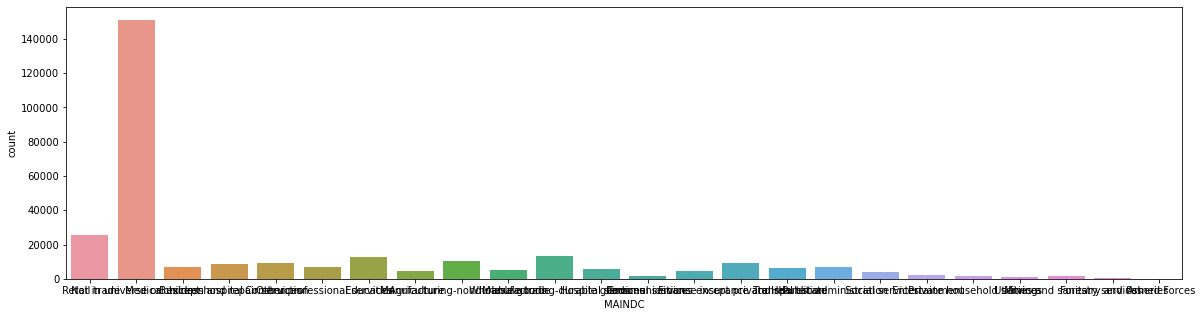

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


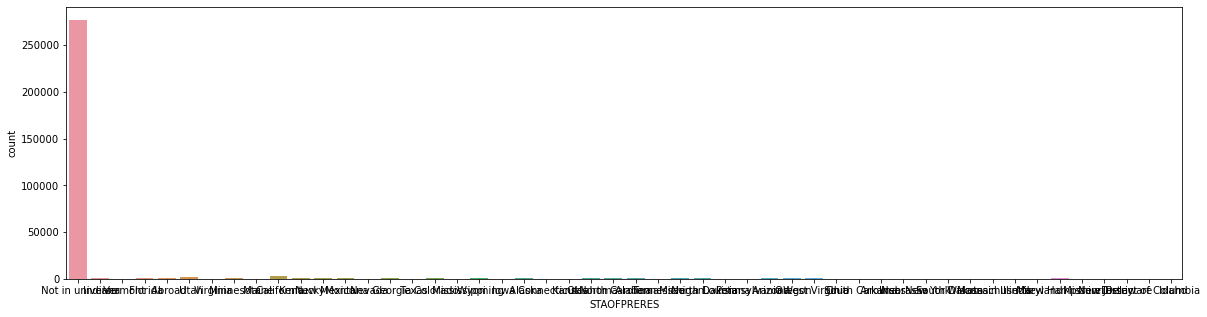

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


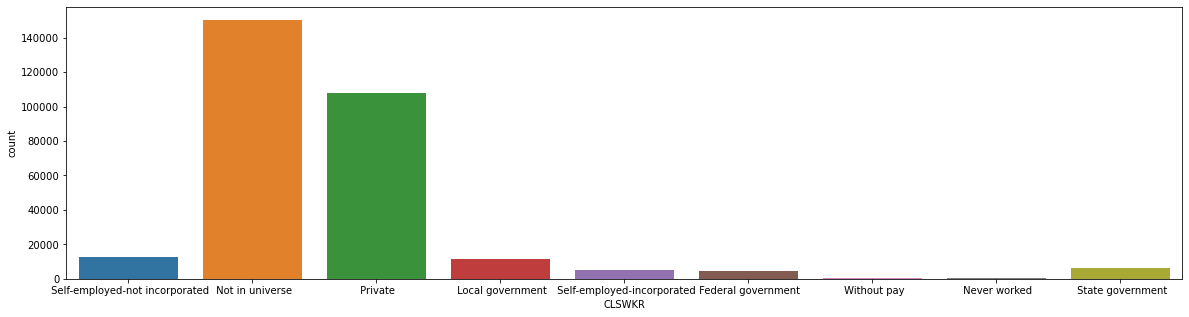

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


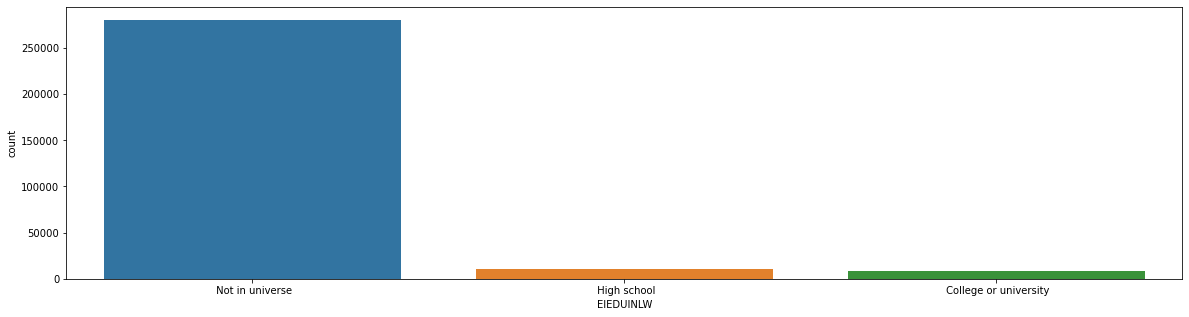

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


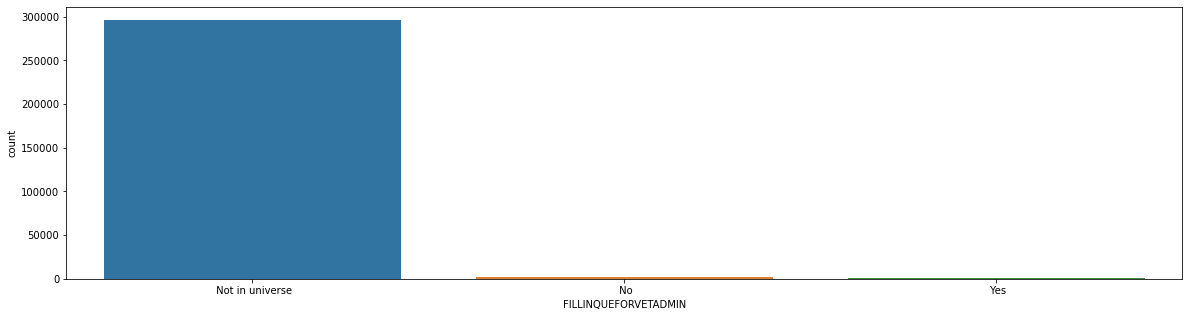

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


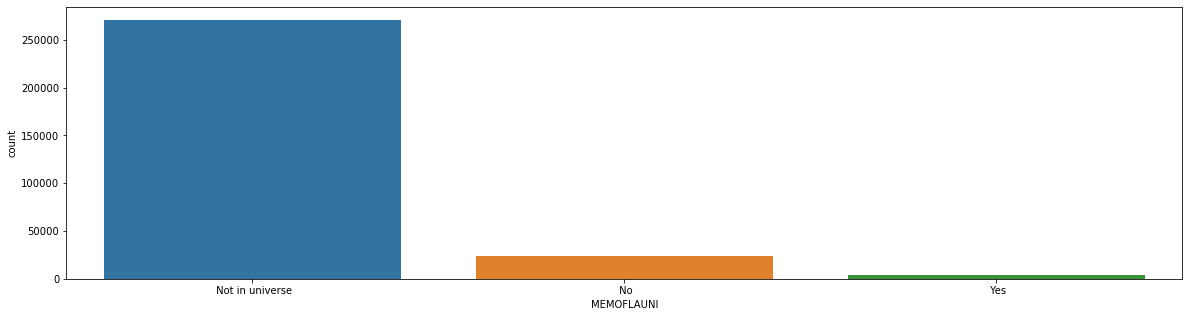

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


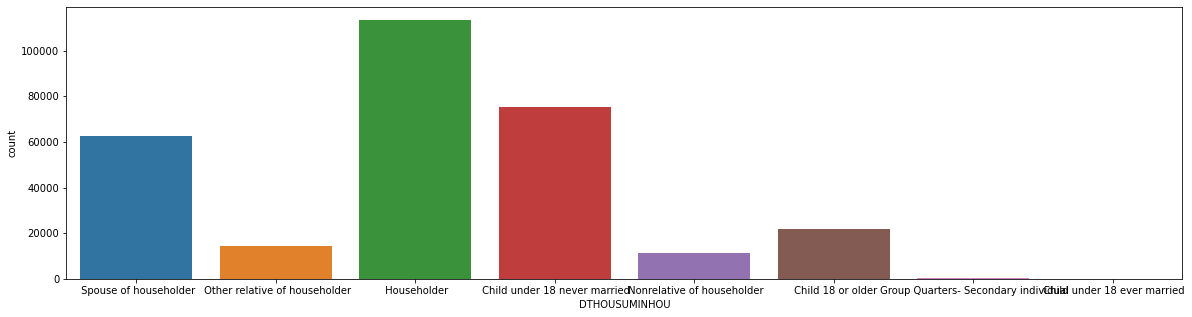

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


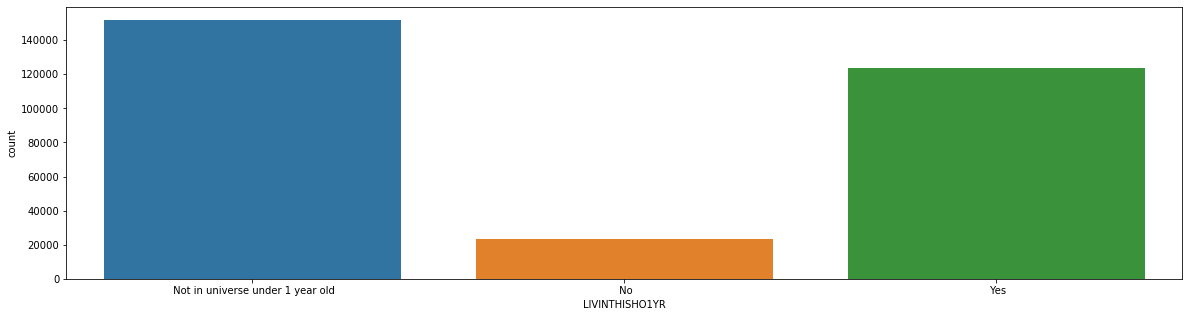

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


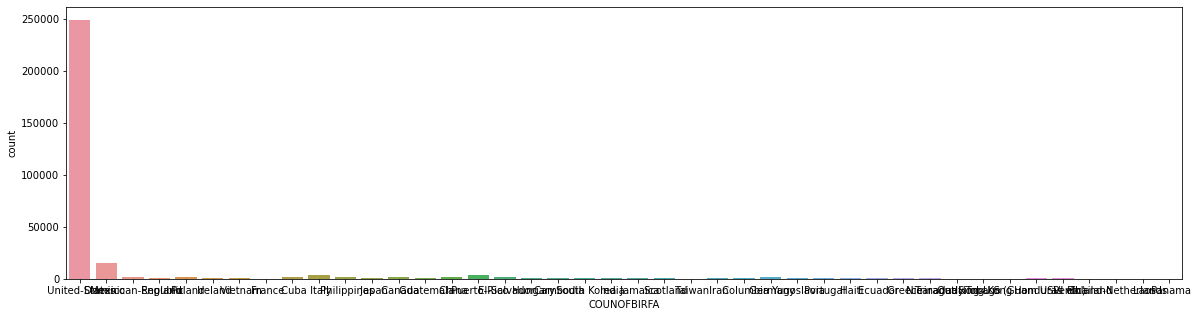

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


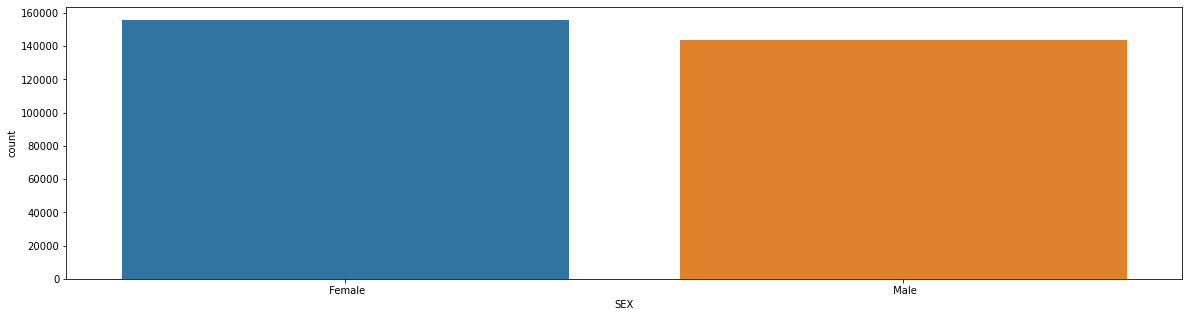

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


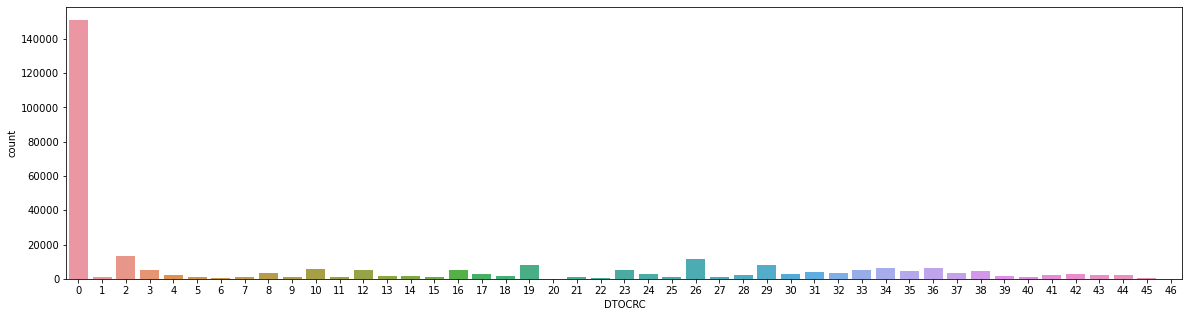

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


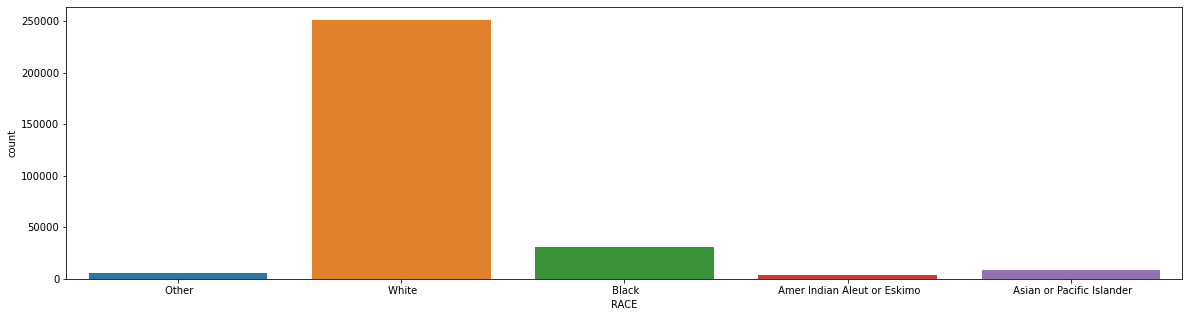

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


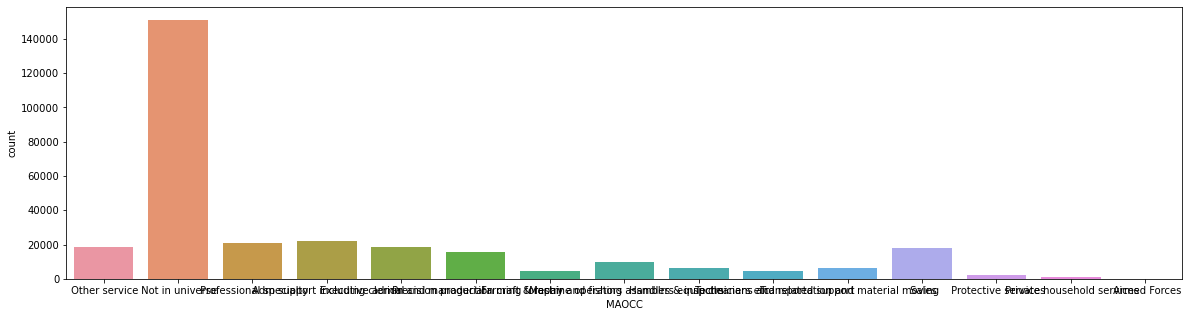

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


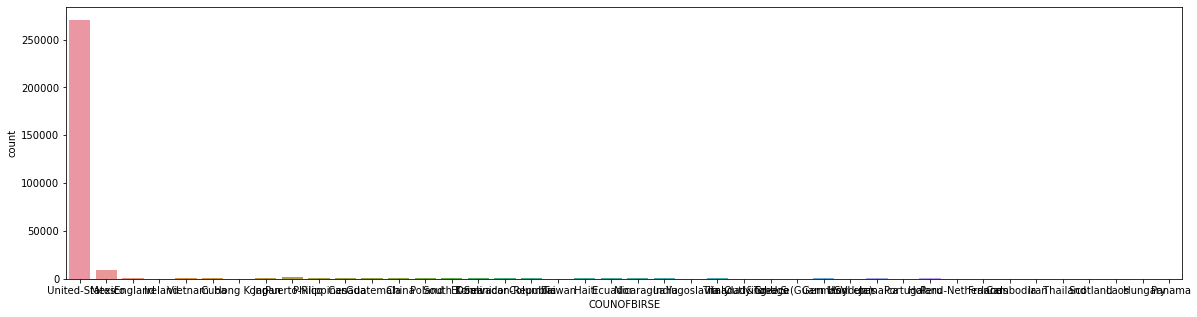

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


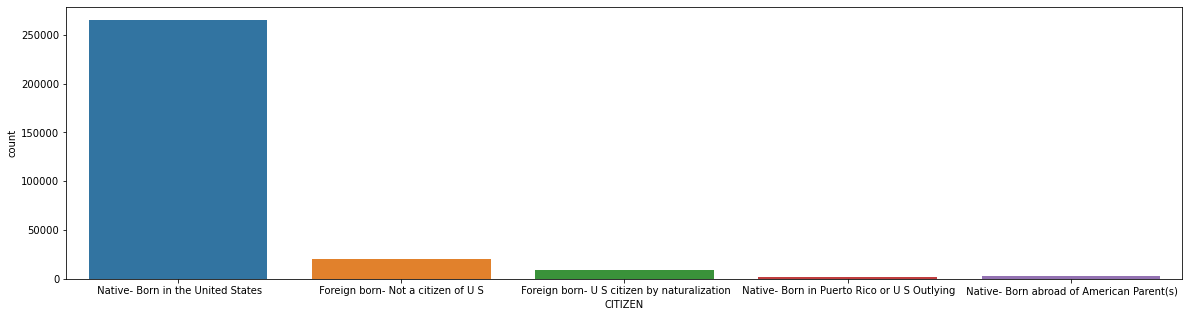

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


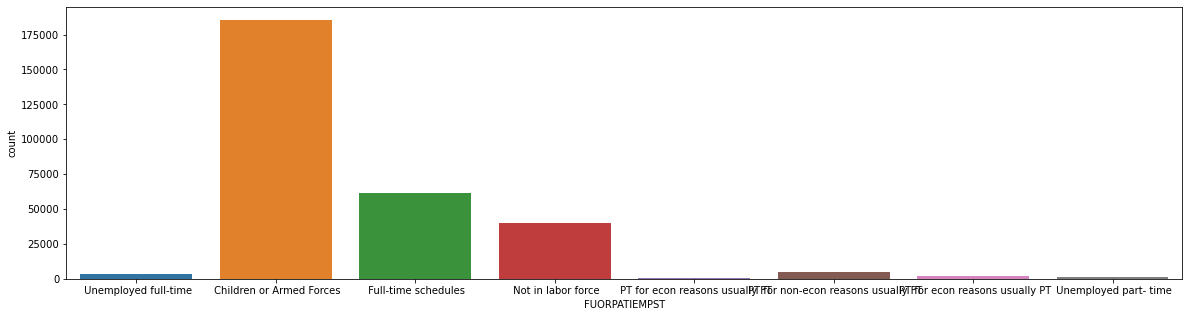

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


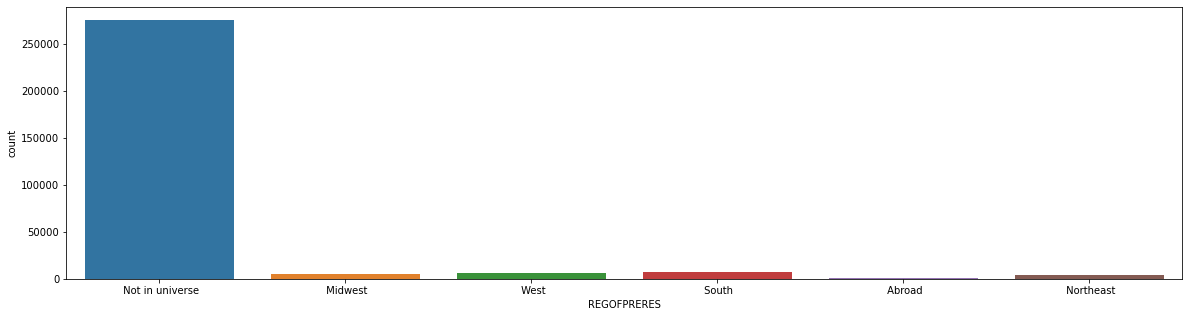

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


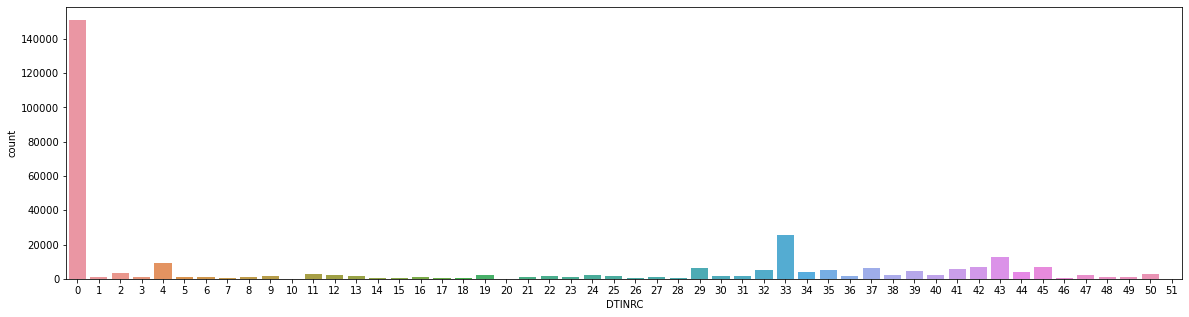

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


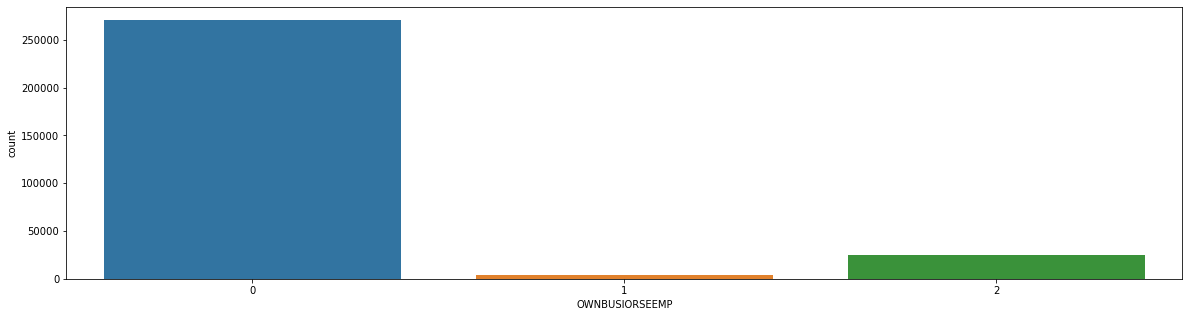

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


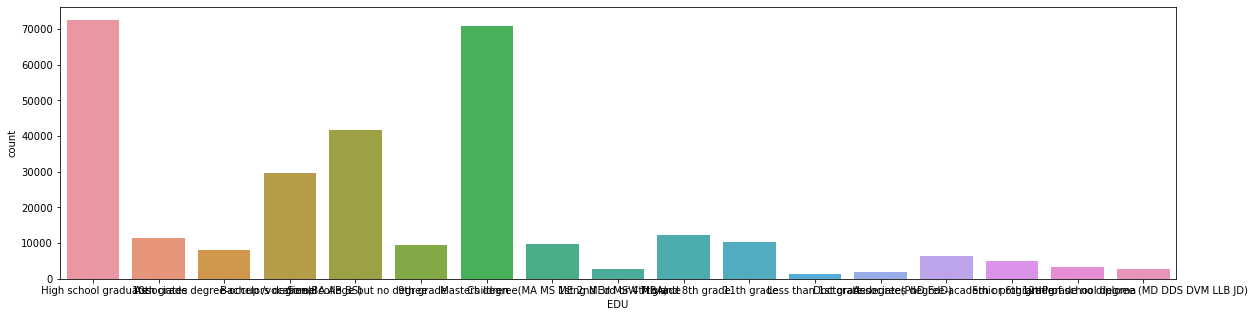

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


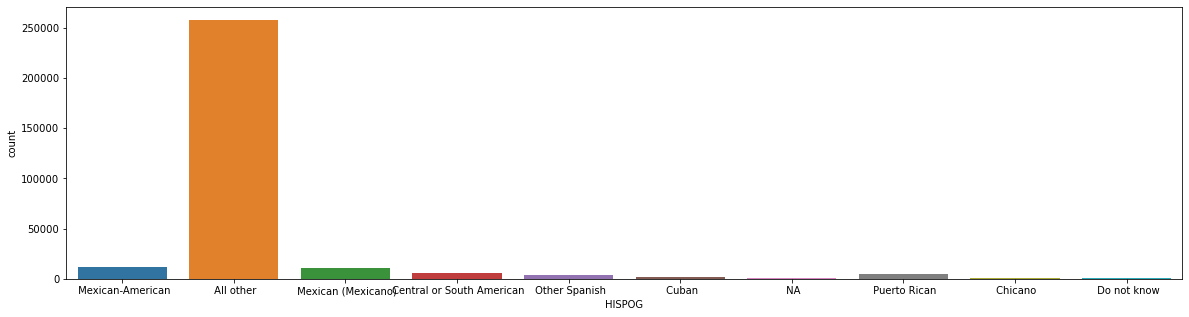

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


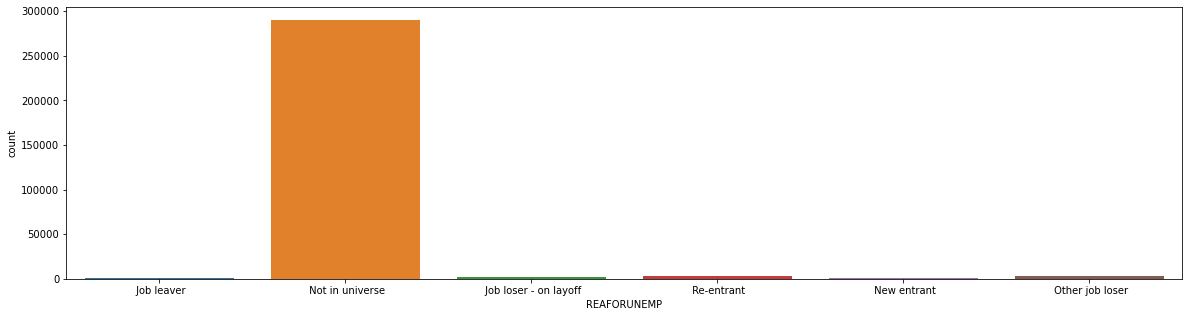

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


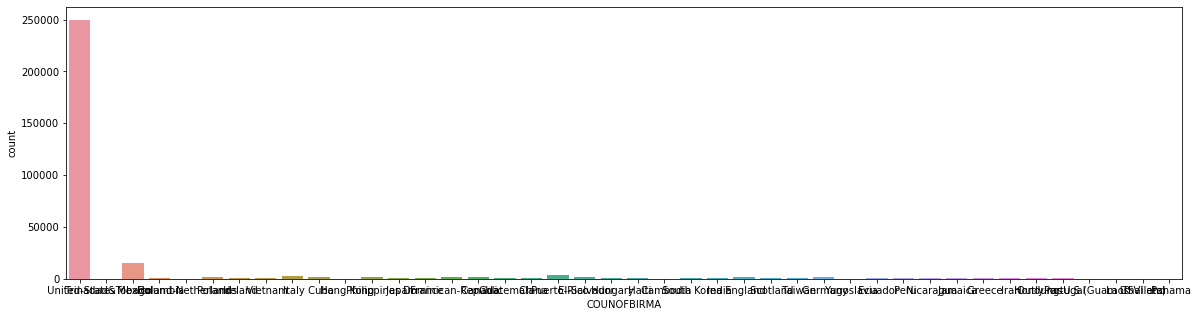

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


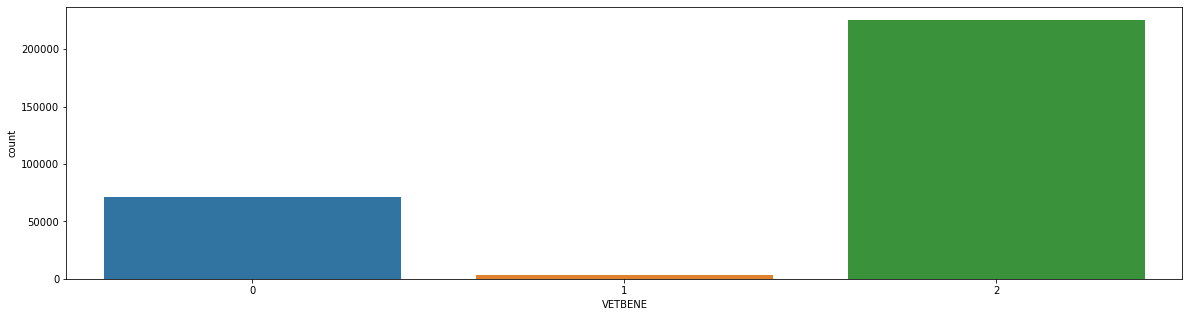

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


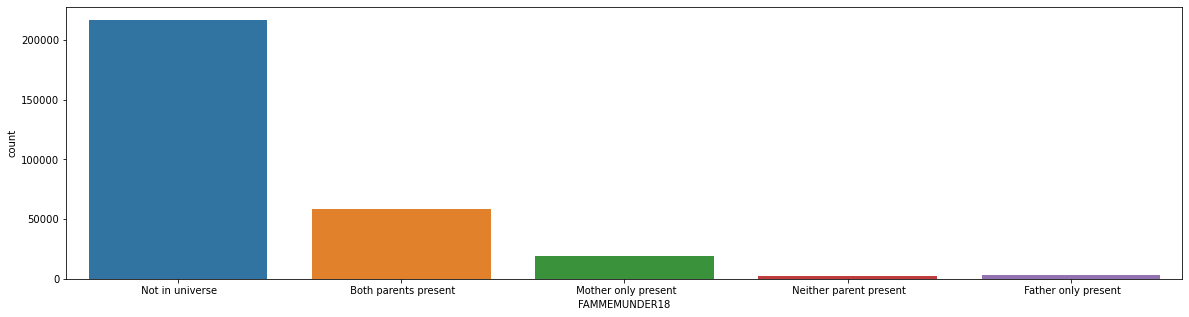

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


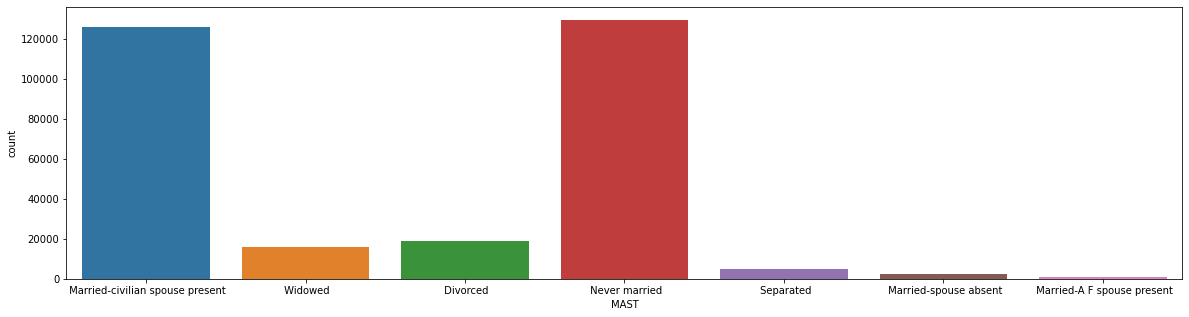

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


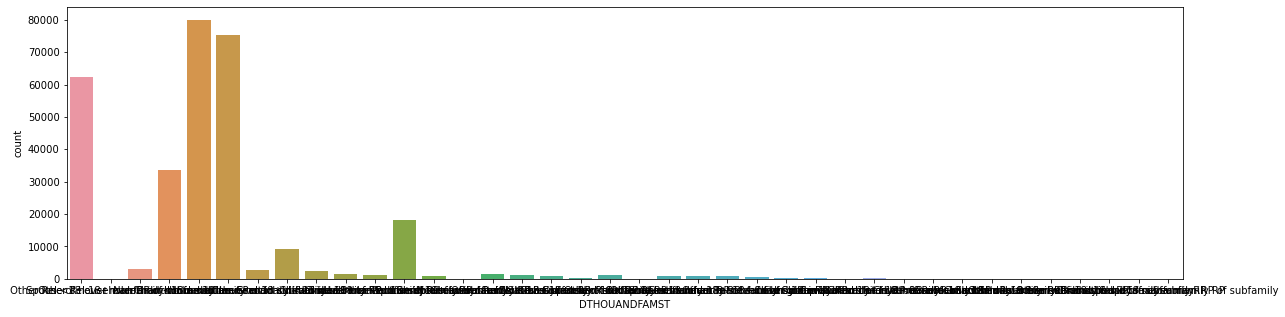

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


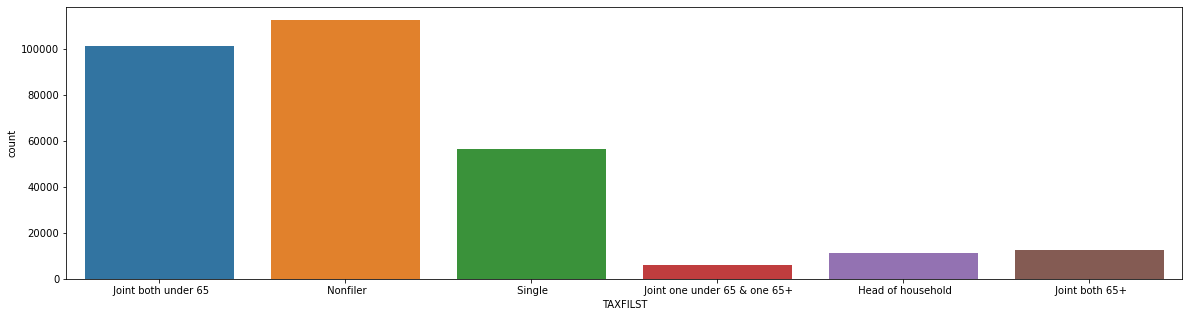

In [125]:
for col in cat_col:
    fig, ax = plt.subplots(figsize=(20, 5))
    fig = sns.countplot(X[col])
    plt.show()

### 4) Handle Continuous Features

I check for the count, number of unique values, mode, and frequency for all continuous features.

In [126]:
print(cont_X.describe())

           AGE     WPH  CAPGAIN  CAPLOSS  DIVFROMSTO  NUMPERWOFOREMP  \
count   299285  299285   299285   299285      299285          299285   
unique      92    1700      372      314        2467               7   
top          0       0        0        0           0               0   
freq      5792  282397   288184   293471      267844          143872   

        WEEKWORKINYEAR    YEAR  
count           299285  299285  
unique              54       2  
top                  0      94  
freq            144108  149643  


Data scaling is recommended for the continuous features. I experimented with various scalers here. However, changing the types of scaler had a minimal impact on the performace of the model. I also deleted the "YEAR" column, because this feature was not important.

In [127]:
cont_X= cont_X.astype(float)

cont_X.drop(['YEAR'], axis=1, inplace=True)

col = cont_X.columns

#scaler = RobustScaler()
#scaler = MinMaxScaler()
#scaler = StandardScaler()

#scaler.fit(cont_X)
#cont_X = scaler.transform(cont_X)

cont_X = np.log1p(cont_X)

print(cont_X)

             AGE  WPH   CAPGAIN  CAPLOSS  DIVFROMSTO  NUMPERWOFOREMP  \
0       3.931826  0.0  0.000000      0.0    0.000000        0.693147   
1       2.890372  0.0  0.000000      0.0    0.000000        0.000000   
2       3.871201  0.0  0.000000      0.0    0.000000        1.945910   
3       4.304065  0.0  0.000000      0.0    0.000000        0.000000   
4       3.806662  0.0  0.000000      0.0    0.000000        0.693147   
...          ...  ...       ...      ...         ...             ...   
299280  3.951244  0.0  0.000000      0.0    7.393878        1.945910   
299281  3.178054  0.0  0.000000      0.0    0.000000        0.000000   
299282  3.091042  0.0  7.999343      0.0    0.000000        1.791759   
299283  3.737670  0.0  0.000000      0.0    0.000000        0.693147   
299284  4.077537  0.0  0.000000      0.0    8.412055        0.000000   

        WEEKWORKINYEAR  
0             3.135494  
1             0.000000  
2             3.988984  
3             0.000000  
4         

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


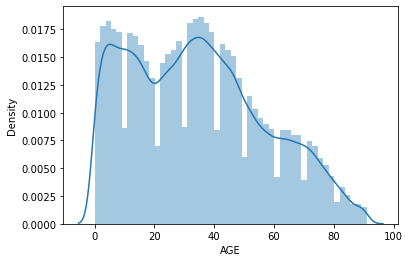

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


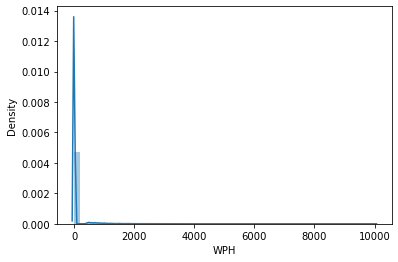

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


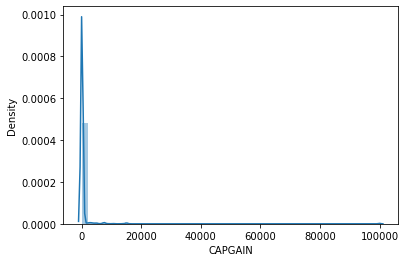

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


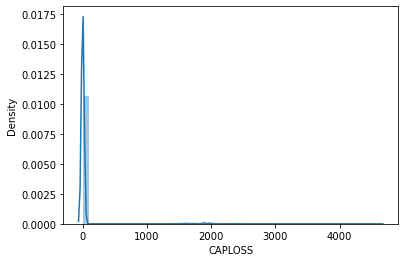

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


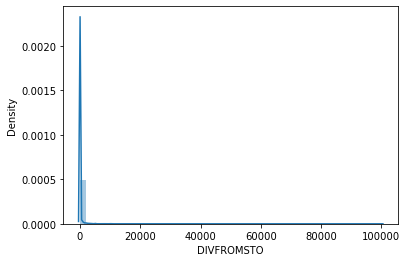

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


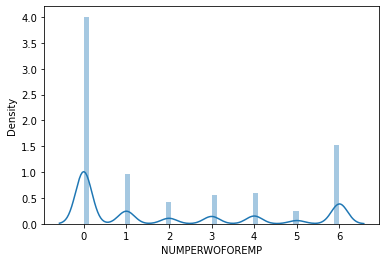

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


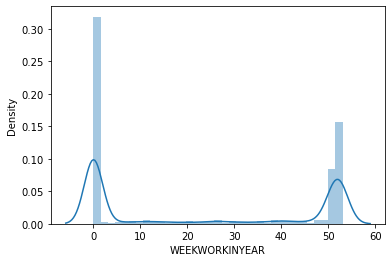

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


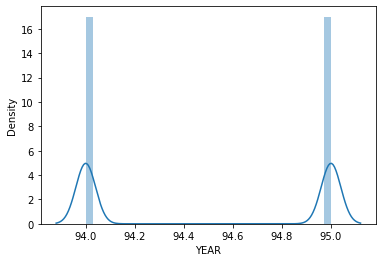

In [128]:
for col in cont_col:
    sns.distplot(X[col])
    plt.show()

When I looked at the box plot for capital gain, I noticed that there is an outlier for capital gain data. I deleted the data point to eliminate outlier's effect on the model. I also combined CAPGAIN and CAPLOSS into a new column NETCAPGAIN.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CAPGAIN'>

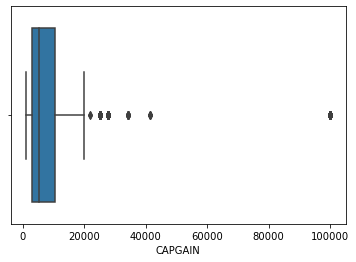

In [129]:
ind=X[(X['CAPGAIN'] <1000)].index
sns.boxplot(X.drop(ind)['CAPGAIN'])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


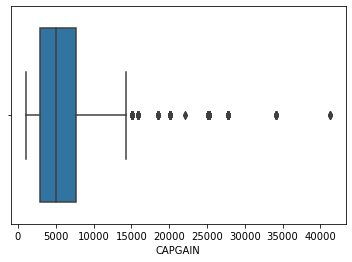

In [130]:
i = X[(X['CAPGAIN'] > 80000)].index
X = X.drop(i)

ind=X[(X['CAPGAIN'] <1000)].index
sns.boxplot(X.drop(ind)['CAPGAIN'])

cont_X['NETCAPGAIN'] = X.apply(lambda x: x['CAPGAIN'] + x['CAPLOSS'], axis=1)
cont_X.drop(['CAPGAIN','CAPLOSS'],axis=1, inplace=True)

In [131]:
train_X = pd.concat([cont_X, cat_X], axis=1)

In [132]:
print(train_X)

             AGE  WPH  DIVFROMSTO  NUMPERWOFOREMP  WEEKWORKINYEAR  NETCAPGAIN  \
0       3.931826  0.0    0.000000        0.693147        3.135494         0.0   
1       2.890372  0.0    0.000000        0.000000        0.000000         0.0   
2       3.871201  0.0    0.000000        1.945910        3.988984         0.0   
3       4.304065  0.0    0.000000        0.000000        0.000000         0.0   
4       3.806662  0.0    0.000000        0.693147        3.988984         0.0   
...          ...  ...         ...             ...             ...         ...   
299280  3.951244  0.0    7.393878        1.945910        3.970292         0.0   
299281  3.178054  0.0    0.000000        0.000000        0.000000         0.0   
299282  3.091042  0.0    0.000000        1.791759        3.988984      2978.0   
299283  3.737670  0.0    0.000000        0.693147        3.970292         0.0   
299284  4.077537  0.0    8.412055        0.000000        0.000000         0.0   

        MAINDC_ Agriculture

To explore the relationships among various attributes, I made plotted a heatmap of numerical attributes excluding the class attribute (income). 

<AxesSubplot:>

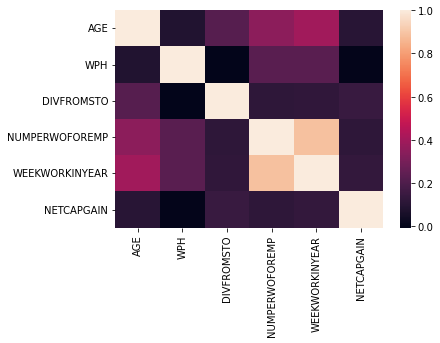

In [133]:
sns.heatmap(cont_X.corr())

NUMPERWOFOREMP (Number of persons worked for employer) and WEEKWORKINYEAR (weeks worked in a year) had high correlation. Other variables had little correlation with each other. 

I also tried Principal COmponent Analysis, a dimensionality reduction technique that transforms a set of features in a dataset into a smaller number of features called principal components while at the same time trying to retain as much information in the original dataset as possible. PCA can help remove correlated features and reduce overfitting. 

In [150]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(cont_X)
imputed_value = imputer.transform(cont_X)
cont_X = pd.DataFrame(imputed_value)

pca = PCA()
pca.fit(cont_X)
print(pca.explained_variance_ratio_)

[0.38385549 0.18988477 0.14990639 0.14369996 0.11402735 0.01862604]
